# MVP

In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# AWS Libraries
import logging
import boto3
from botocore.exceptions import ClientError

# NLP Libraries
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Geo-mapping Libraries
import geopandas
import geopy
import folium 

# Helper Functions
import MVP_acquire_ds, MVP_explore

# Skill Libray
import library

import warnings
warnings.filterwarnings("ignore")

## Data Acquisition

### Download the JSON Files from AWS S3 Bucket

In [2]:
# Create the s3 resource object
s3 = boto3.resource('s3')

# Download the json files from AWS

s3.Bucket("dspreparedjobpostings").download_file("df_ds_tx_prepared_backup.json", 
                                                 "df_ds_tx_prepared_backup.json")

# Print the last modified datetime of the prepared file of data scientist positions in TX
print("Last modified datetime for data scientist positions in TX: ", 
      s3.Object('dspreparedjobpostings', 'df_ds_tx_prepared_backup.json').last_modified)

s3.Bucket("wdpreparedjobpostings").download_file("df_wd_tx_prepared_backup.json", 
                                                 "df_wd_tx_prepared_backup.json")

# Print the last modified datetime of the prepared file of web developer positions in TX
print("Last modified datetime for web developer positions in TX: ", 
      s3.Object('wdpreparedjobpostings', 'df_wd_tx_prepared_backup.json').last_modified)

Last modified datetime for data scientist positions in TX:  2021-03-08 03:09:45+00:00
Last modified datetime for web developer positions in TX:  2021-03-08 03:13:27+00:00


## Data Preparation

### Load JSON Files into Dataframe and Set the Date as the Index

In [3]:
# Read the json file and convert it to pandas dataframe

df_ds = pd.read_json('df_ds_tx_prepared_backup.json')
df_wd = pd.read_json('df_wd_tx_prepared_backup.json')

# Set the date column as the index and sort the index

df_ds.date = pd.to_datetime(df_ds.date)
df_ds = df_ds.set_index('date').sort_index(ascending=False)
df_wd.date = pd.to_datetime(df_wd.date)
df_wd = df_wd.set_index('date').sort_index(ascending=False)

# Print the number of job postings in each dataframe

print("Number of data scientist job postings in TX: ", df_ds.shape[0])
print("Number of web developer job postings in TX: ", df_wd.shape[0])

Number of data scientist job postings in TX:  2668
Number of web developer job postings in TX:  5206


In [4]:
# Print the concise summary of the dataframe df_ds
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2668 entries, 2021-03-07 to 2020-12-22
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            2668 non-null   object 
 1   company          2668 non-null   object 
 2   company_rating   2668 non-null   float64
 3   job_link         2668 non-null   object 
 4   job_description  2668 non-null   object 
 5   city             2668 non-null   object 
 6   state            2668 non-null   object 
 7   zipcode          2668 non-null   int64  
 8   clean            2668 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 208.4+ KB


In [5]:
# Print the concise summary of the dataframe df_wd
df_wd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5206 entries, 2021-03-07 to 2021-01-04
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            5206 non-null   object 
 1   company          5206 non-null   object 
 2   company_rating   5206 non-null   float64
 3   job_link         5206 non-null   object 
 4   job_description  5206 non-null   object 
 5   city             5206 non-null   object 
 6   state            5206 non-null   object 
 7   zipcode          5206 non-null   int64  
 8   clean            5206 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 406.7+ KB


In [6]:
# Print the first 5 rows of the dataframe df_ds
df_ds.head()

,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
date,,,,,,,,,
2021-03-07,Data Scientist,Corvus Insurance,3.77,https://www.indeed.com/rc/clk?jk=6ab228ff6f860...,We're united by a mission: to make the world a...,Austin,TX,0,united mission make world safer place corvus i...
2021-03-07,Associate Data Scientist,Corvus Insurance,3.77,https://www.indeed.com/rc/clk?jk=c1c8c69521913...,We're united by a mission: to make the world a...,Austin,TX,0,united mission make world safer place corvus i...
2021-03-07,"Return to Work - Data Scientist, Product Analy...",Facebook,4.20,https://www.indeed.com/rc/clk?jk=7e2b4a9ce43b6...,We’re looking for Data Scientists to help shap...,Austin,TX,0,looking data scientist help shape future build...
2021-03-07,Data Science Engineer,Solera,2.40,https://www.indeed.com/rc/clk?jk=8005a4aa713bd...,The Role\n\nWe are looking for Data Science En...,Westlake,TX,0,role looking data science engineer pytorch ker...
2021-03-07,Data Scientist Sr. Associate,"JPMorgan Chase Bank, N.A.",3.90,https://www.indeed.com/rc/clk?jk=2db81708e4c1c...,The Data Scientist is an individual contributo...,Lewisville,TX,0,data scientist individual contributor able app...


In [7]:
# Print the first 5 rows of the dataframe df_wd
df_wd.head()

,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
date,,,,,,,,,
2021-03-07,REMOTE Senior Software Developer,CyberCoders,3.2,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,REMOTE Senior Software Developer\nIf you are a...,Austin,TX,78701,remote senior software developer senior softwa...
2021-03-07,Front End Lead Engineer,Lasso,3.7,https://www.indeed.com/rc/clk?jk=11cd599a13d26...,We're rapidly growing and looking for super cu...,Austin,TX,78746,rapidly growing looking super curious passiona...
2021-03-07,"PHP, Laravell, and Python Developer Interns",United Vehicle Group,3.7,https://www.indeed.com/company/Croft-Ventures-...,"We are looking for a PHP, Laravell, and Python...",Frisco,TX,75033,looking php laravell python development intern...
2021-03-07,SharePoint Developer,Seer Solutions Inc.,3.7,https://www.indeed.com/company/Seer-Solutions-...,SharePoint DeveloperLocation: Dallas TX Durati...,Dallas,TX,75202,sharepoint developerlocation dallas tx duratio...
2021-03-07,Professional C#.Net Product Developer,Gainwell Technologies,2.0,https://www.indeed.com/rc/clk?jk=e929cde7597e0...,Job Description:\nEssential Job Functions\nRec...,El Paso,TX,79901,job description essential job function recomme...


### Brief Summary of the Job Postings

#### Data Scientist Position

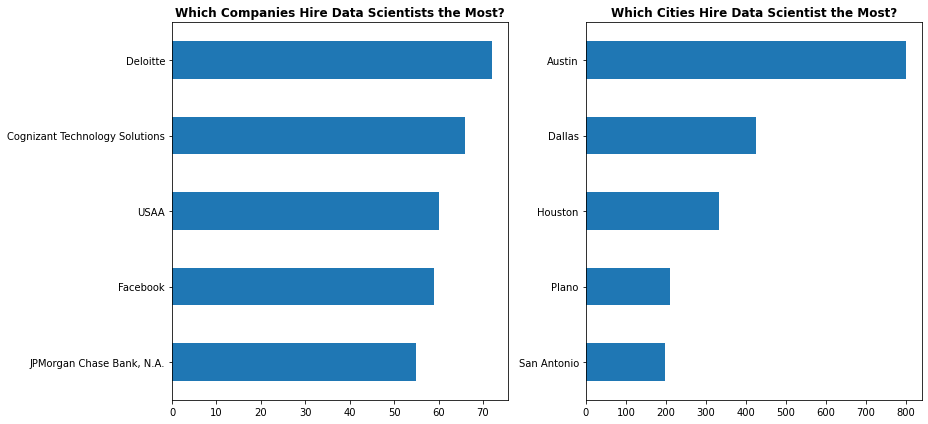

In [8]:
# Barplot the top 5 companies and top 5 cities by the number of the job posts

plt.figure(figsize=(13,6))

plt.subplot(121)
top_companies = df_ds.company.value_counts().head(5)
top_companies.sort_values().plot(kind='barh')
plt.title("Which Companies Hire Data Scientists the Most?", fontweight='bold')

plt.subplot(122)
top_cities = df_ds.city.value_counts().head(5)
top_cities.sort_values().plot(kind='barh')
plt.title("Which Cities Hire Data Scientist the Most?", fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# How does the number of job postings change over time?
df_ds.resample('W').title.count()

date
2020-12-27    392
2021-01-03    136
2021-01-10    212
2021-01-17    187
2021-01-24    352
2021-01-31    295
2021-02-07    269
2021-02-14    299
2021-02-21    180
2021-02-28    208
2021-03-07    138
Freq: W-SUN, Name: title, dtype: int64

In [10]:
# Which company has the best avereage rating? 
df_ds.groupby('company').company_rating.mean().sort_values(ascending=False).head()

company
Digital Pharmacist    5.0
Rekruiters            5.0
Onit                  4.7
Levelset              4.7
Harnham               4.6
Name: company_rating, dtype: float64

In [11]:
df_ds.title.value_counts().head()

Data Scientist               278
Senior Data Scientist        100
Senior Data Analyst           57
Machine Learning Engineer     55
Sr. Data Scientist            43
Name: title, dtype: int64

#### Web Developer Position

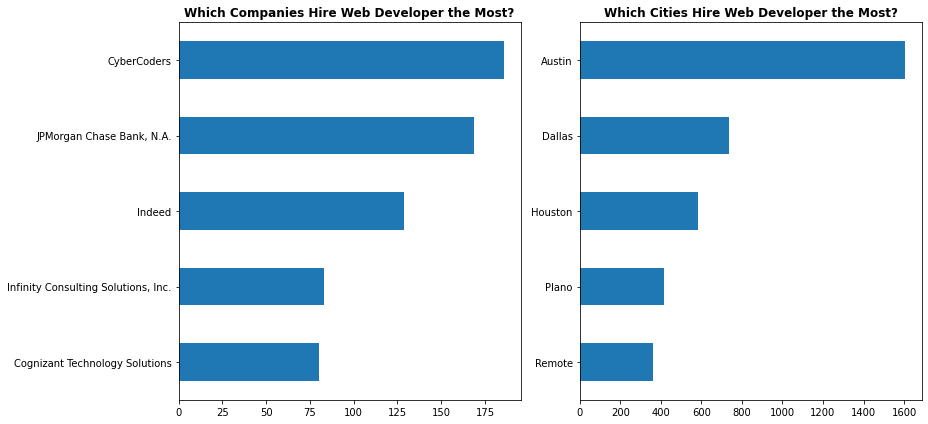

In [12]:
# Barplot the top 5 companies and top 5 cities by the number of the job posts

plt.figure(figsize=(13,6))

plt.subplot(121)
top_companies = df_wd.company.value_counts().head(5)
top_companies.sort_values().plot(kind='barh')
plt.title("Which Companies Hire Web Developer the Most?", fontweight='bold')

plt.subplot(122)
top_cities = df_wd.city.value_counts().head(5)
top_cities.sort_values().plot(kind='barh')
plt.title("Which Cities Hire Web Developer the Most?", fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
# How does the number of job postings change over time?
df_wd.resample('W').title.count()

date
2021-01-10      62
2021-01-17     346
2021-01-24     793
2021-01-31    1054
2021-02-07     825
2021-02-14     786
2021-02-21     452
2021-02-28     496
2021-03-07     392
Freq: W-SUN, Name: title, dtype: int64

In [14]:
# Which company has the best avereage rating? 
df_wd.groupby('company').company_rating.mean().sort_values(ascending=False).head()

company
Box                    5.0
ALAANT                 5.0
The Evolvers Group     5.0
Royal & Ross           5.0
RightNow Ministries    5.0
Name: company_rating, dtype: float64

In [15]:
df_wd.title.value_counts().head()

Web Developer               119
Software Engineer           117
Software Developer           83
Senior Software Engineer     81
Full Stack Developer         74
Name: title, dtype: int64

### Top k Needed Skills

#### Data Scientist Position
- Tech Skills
- Soft Skills
- General Skills (Combination of Tech+Soft)

In [17]:
# Import library
ds_tech_library = library.library_ds_tech

# Print the number of skills in the library
print("Number of data science skills in tech skill library: ", len(ds_tech_library))

# Print the top 5 needed tech skills

ds_top_tech = MVP_explore.top_skills(df_ds, 5, ds_tech_library, 'tech')
ds_top_tech

Number of data science skills in tech skill library:  71
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_tech_skills,frequency
0,machine learning,4040.0
1,python,2155.0
2,sql,1623.0
3,aws,1262.0
4,r,1189.0


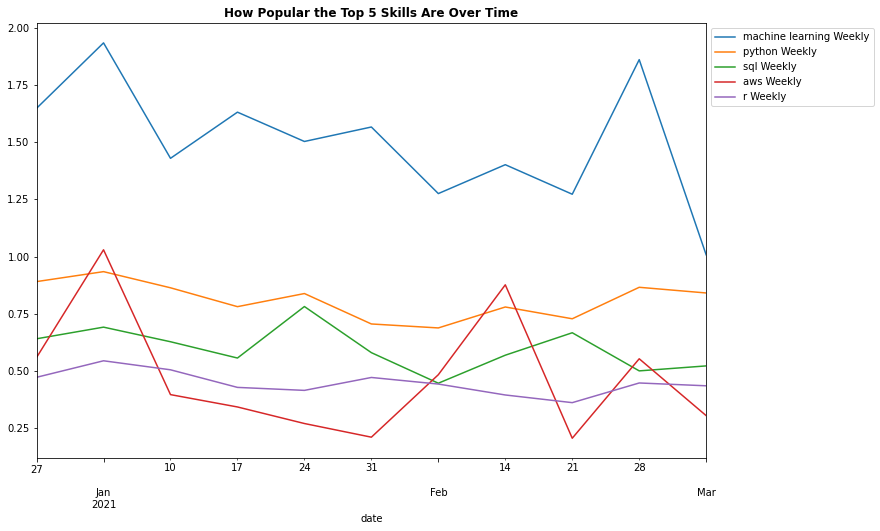

In [18]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_tech)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_tech)

In [19]:
# Import library
ds_soft_library = library.library_ds_soft

# Print the number of skills in the library
print("Number of data science skills in soft skill library: ", len(ds_soft_library))

# Print the top 5 needed soft skills

ds_top_soft = MVP_explore.top_skills(df_ds, 5, ds_soft_library, 'soft')
ds_top_soft

Number of data science skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_soft_skills,frequency
0,communication,1819.0
1,leadership,1174.0
2,collaboration,533.0
3,problem solving,395.0
4,written communication,306.0


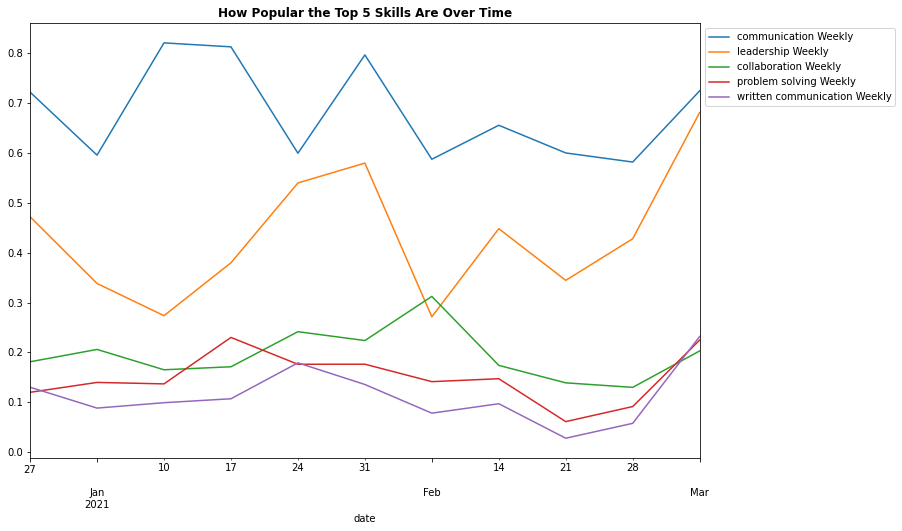

In [20]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_soft)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_soft)

In [21]:
# Import library
ds_general_library = library.library_ds_general

# Print the number of skills in the library
print("Number of data science skills in general skills library: ", len(ds_general_library))

# Print the top 5 needed general skills

ds_top_general = MVP_explore.top_skills(df_ds, 5, ds_general_library, 'general')
ds_top_general

Number of data science skills in general skills library:  90
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_general_skills,frequency
0,machine learning,4040.0
1,python,2155.0
2,communication,1819.0
3,sql,1623.0
4,aws,1262.0


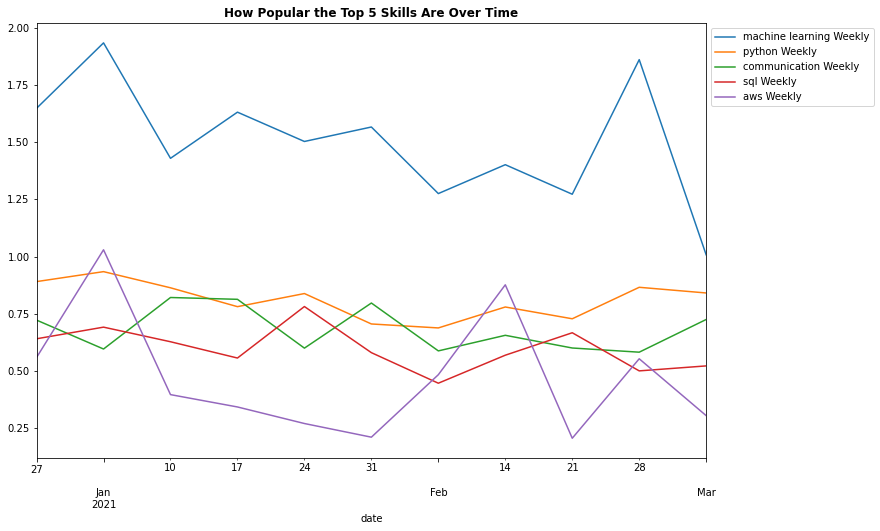

In [22]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_general)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_general)

#### Web Developer Position
- Tech skills
- Soft skills
- General Skills (Combination of Tech+Soft)

In [23]:
# Import library
wd_tech_library = library.library_wd_tech

# Print the number of skills in the library
print("Number of web dev skills in tech skill library: ", len(wd_tech_library))

# Print the top 5 needed tech skills

wd_top_tech = MVP_explore.top_skills(df_wd, 5, wd_tech_library, 'tech')
wd_top_tech

Number of web dev skills in tech skill library:  67
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_tech_skills,frequency
0,javascript,4118.0
1,java,2745.0
2,sql,2500.0
3,react,2196.0
4,net,2067.0


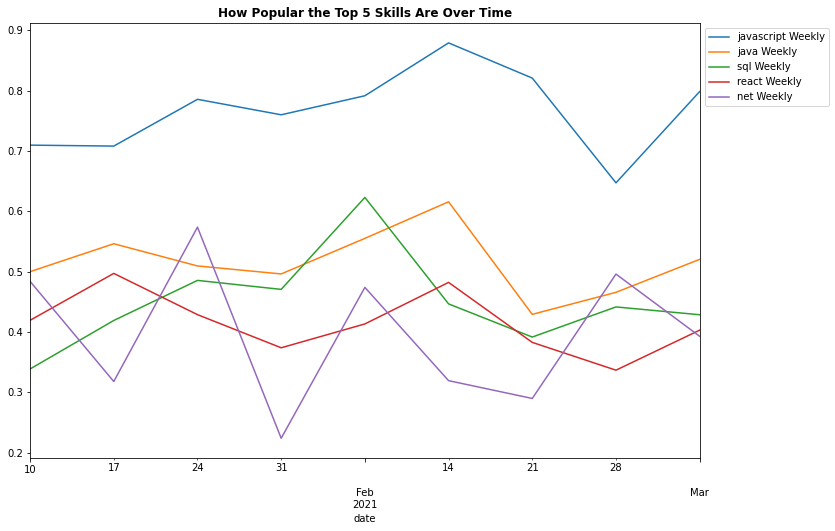

In [24]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_tech)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_tech)

In [25]:
# Import library
wd_soft_library = library.library_wd_soft

# Print the number of skills in the library
print("Number of web dev skills in soft skill library: ", len(wd_soft_library))

# Print the top 5 needed soft skills

wd_top_soft = MVP_explore.top_skills(df_wd, 5, wd_soft_library, 'soft')
wd_top_soft

Number of web dev skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_soft_skills,frequency
0,communication,3050.0
1,leadership,1188.0
2,collaboration,812.0
3,problem solving,652.0
4,written communication,456.0


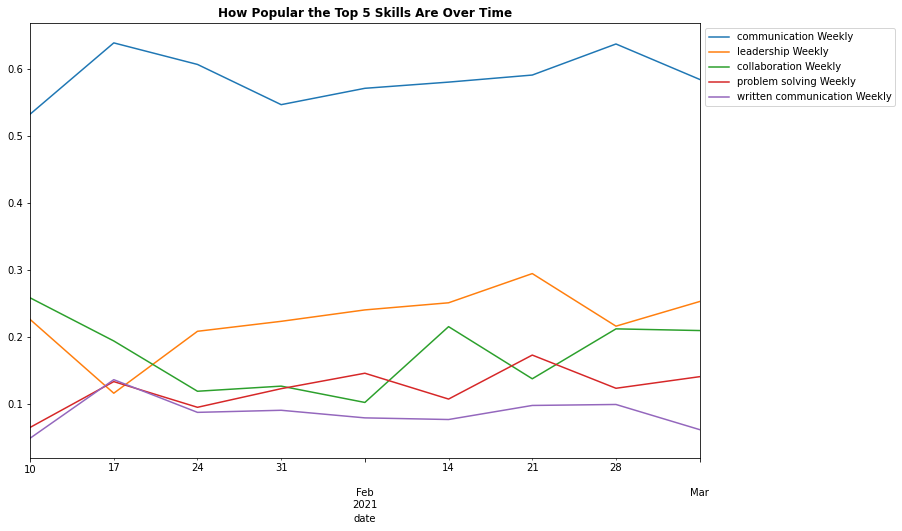

In [26]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_soft)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_soft)

In [27]:
# Import library
wd_general_library = library.library_wd_general

# Print the number of skills in the library
print("Number of web dev skills in general skill library: ", len(wd_general_library))

# Print the top 5 needed general skills

wd_top_general = MVP_explore.top_skills(df_wd, 5, wd_general_library, 'general')
wd_top_general

Number of web dev skills in general skill library:  86
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_general_skills,frequency
0,javascript,4118.0
1,communication,3050.0
2,java,2745.0
3,sql,2500.0
4,react,2196.0


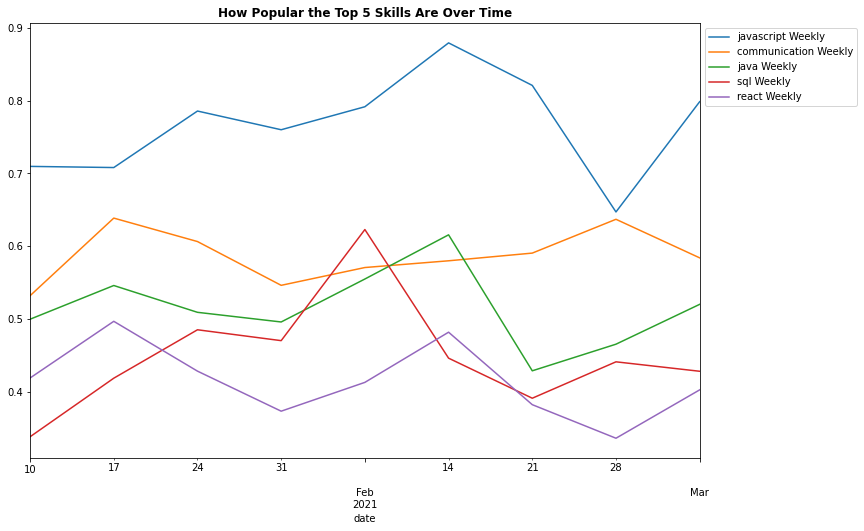

In [28]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_general)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_general)